# OPTRAM

In [45]:
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime, timedelta
import math
import rasterio as rs
from scipy import stats
import sys
import glob
import haversine as hs
from haversine import Unit
from shapely.geometry import Point
from os import listdir
from os.path import isfile, join
import timeit

### Functions

In [38]:
def utm_to_latlon(coords, zone_number = 12, zone_letter = 'N'):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt

# TODO unify funcs S2_get*
def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)
        
def S2_getNDVI(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except Exception as e: 
        print('Error while reading file %s' % pattern)
        print(e)
        
def S2_get_sensing_dt(boa_fp):
    days_offset = 1
    start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
    end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)
    
    start_dt = start_dt.strftime('%Y-%m-%d')
    end_dt   = end_dt.strftime('%Y-%m-%d')

    now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    print('[%s] : Requesting image metadata between %s <-> %s...' % (now, start_dt, end_dt))
    # bash callback: 
    dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')
    return sensing_datetime


def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc

def get_px_coords_from_raster(boa) :
    print('[%s] : Retrieving px location coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    dataset = boa
    val = boa.read(3, masked = True)
    no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
    return (zip(*coords_utm))

# TODO: add aditional col for sensor name
def build_inSitu_obs(df, dest_lat_lng, sensor_df, dists, utm_n = 12, utm_z = 'N') :
    
    # Calculate the closest image pixel to the sensor
    x = df.loc[:,'utm_x'].tolist()
    y = df.loc[:,'utm_y'].tolist()
    
    #print('[%s] : Calculating haversine distance for %d rows...'
    #      % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    #dists = [  hs.haversine(utm_to_latlon(item, utm_n, utm_Z),
    #                        dest_lat_lng, unit = Unit.METERS)
    #    
    #           for item in zip(x,y) 
    #]
    #print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df['dist'] = dists
    
    print('[%s] : Sorting %d rows...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    df.sort_values('dist', inplace = True)
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df = df.head(1)
    df.set_index('datetime', inplace = True)
    
    # Get the corresponding sensor obs to the pixel
    
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
              
    nearest_dt = nearest(items = sensor_df.index, pivot = df.index[0])
    val = sensor_df.loc[sensor_df.index == nearest_dt, 'SM5'].values
    print('nearest_dt: %s, %s'% (nearest_dt, val))
    df.loc[:,'SM5'] = val
    return df


def get_haversine_dist_df(utm_coords, sensor_coords, sensor_name, utm_n = 12, utm_z = 'N') : 
   # Calculate the closest image pixel to the sensor
    #x = sensor_df.loc[:,'utm_x'].tolist()
    #y = sensor_df.loc[:,'utm_y'].tolist()

    print('[%s] : Calculating haversine distance for sensor %s...'
          % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), sensor_name))
    
    dists = [  hs.haversine(utm_to_latlon(utm_coord, utm_n, utm_Z),
                            sensor_coords, unit = Unit.METERS)
        
               for utm_coord in utm_coords 
    ]
    
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    return(dists)

def get_distances_pxs_to_sensor(boa_dummy, sensors_coords, utm_x, utm_y):
    #boa_fp = BASE_DIR_BOA + boa_files[0]
    #boa_dummy  = rs.open(boa_fp)
    h_dists = { sensor_name : get_haversine_dist_df(utm_coords = zip(utm_x, utm_y),
                                                    sensor_coords = sensors_coords[sensor_name],
                                                    sensor_name = sensor_name) 
                    for sensor_name, sensor_coords in sensors_coords.items()} 
    return (h_dists)

In [39]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)
    

## REGION OF STUDY


In [40]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


Plotting with Folium requires lat, long data, so we have to convert from UTM

In [41]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [42]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html


sensor_coords_utm = {'rg13vt19'  : [586110, 3510185],
                     'rg14vt19'  : [585442, 3507187],
                     #'rg18vt19'  : [586710, 3508098],
                     'rg20vt19'  : [587480, 3504939],
                     'rg28vt19'  : [590624, 3509990],
                     'rg34vt19'  : [590946, 3507458],
                     'rg37vt19'  : [593303, 3506068],
                     'rg40vt19'  : [593360, 3510286],
                     'rg46vt19'  : [595289, 3508655],
                     'rg57vt19'  : [596089, 3510781],
                     'rg69vt19'  : [603916, 3515463],
                     'rg70vt19'  : [604288, 3514207],
                     'rg76vt19'  : [582624, 3509679],
                     'rg82vt19'  : [600154, 3511680],
                     'rg83vt19'  : [589679, 3512426],
                     'rg89vt19'  : [596308, 3513931],
                     'rg92vt19'  : [581888, 3511774],
                     'rg100vt19' : [593266, 3504720]
}

sensors_coords = {s_key : utm_to_latlon(s_utm, utm_N, utm_Z) 
                  for s_key, s_utm in sensor_coords_utm.items()}

In [43]:
m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
for sensor_key, sensor_coords in sensors_coords.items():
    
    folium.Marker(sensor_coords, popup=sensor_key).add_to(m)
    m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

 Shapefile to geojson conversion

In [44]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [ ]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
url_base = 'https://www.tucson.ars.ag.gov/metDAP/'

sensors_df = {}

start = timeit.default_timer()

for sensor_key,_ in sensors_coords.items() :
    print("Processing sensor %s" % sensor_key)
    try: 
        if 'rg' in sensor_key :

            sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',
                                                 sep='\,', 
                                                 names = names)
        else :
            sensors_df[sensor_key] = pd.read_csv(url_base + 'SoilProfileSiteData/' + sensor_key +'.out',
                                                 sep='\s+', 
                                                 names = names)
    except :
        print("An error occurred while reading data for sensor %s " % sensor_key)

for sensor_key,sensor_df in list(sensors_df.items()) :    
    
    try :       
        sensors_df[sensor_key]['datetime'] = (pd.to_datetime(sensor_df['year'] * 1000 + sensor_df['day'], format='%Y%j') 
                                           +
                                          pd.to_timedelta(sensor_df["hr"], unit="h") 
                                           +
                                          pd.to_timedelta(sensor_df["mn"], unit="min"))
        sensors_df[sensor_key].set_index('datetime', inplace = True)
        sensors_df[sensor_key].replace(6999, None, inplace = True)

    except  Exception as e:
        print("An error occurred while processing data for sensor %s " % sensor_key)
        print("Original message: %s " % e)
        del sensors_df[sensor_key]
        del sensors_coords[sensor_key]
        
stop = timeit.default_timer()
print('Runtime: %f seconds ' % (stop - start))  

Processing sensor rg13vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg14vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg20vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg28vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg34vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg37vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg40vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Processing sensor rg46vt19


/tmp/ipykernel_20102/3400649900.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',


Both rg82 & rg83 need custom processing

In [ ]:
col_nums = 1  
row_nums = math.ceil(len(sensors_df.items()) / col_nums)
plt.figure(figsize=(20, 35))
for i, (k, df) in enumerate(sensors_df.items(), 1):
    plt.subplot(row_nums, col_nums, i)
    plt.scatter(x = df.index, y= df.loc[:,'SM5'])
    plt.title(k)
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2 , wspace=None, hspace=None)

### Satellite

In [9]:
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA2/'
BASE_DIR_NDVI = './sen2r/indices/NDVI/'

boa_files = [f for f in listdir(BASE_DIR_BOA,) if isfile(join(BASE_DIR_BOA, f))]
inSitu_obs_dict = { sensor_name:[] for sensor_name,_ in sensors_coords.items()}

In [10]:
# ----------------------------------PRECALCULATED for speedup
print('[%s] : ------- PRECOMPUTING  -------\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
boa_dummy  = rs.open(BASE_DIR_BOA + boa_files[0])
utm_x, utm_y =  get_px_coords_from_raster(boa_dummy)
haversine_dists = get_distances_pxs_to_sensor(boa_dummy = boa_dummy,
                                              sensors_coords = sensors_coords,
                                              utm_x = utm_x,
                                              utm_y = utm_y)
print('[%s] : ----- PRECOMPUTING DONE -----\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))

[2022/03/23 01:26:53] : ------- PRECOMPUTING  -------

[2022/03/23 01:26:53] : Retrieving px location coords...
[2022/03/23 01:28:15] : Done

[2022/03/23 01:28:20] : Calculating haversine distance for sensor rg13vt19...
[2022/03/23 01:29:34] : Done

[2022/03/23 01:29:34] : Calculating haversine distance for sensor rg14vt19...
[2022/03/23 01:30:49] : Done

[2022/03/23 01:30:49] : Calculating haversine distance for sensor rg20vt19...
[2022/03/23 01:32:03] : Done

[2022/03/23 01:32:03] : Calculating haversine distance for sensor rg28vt19...
[2022/03/23 01:33:18] : Done

[2022/03/23 01:33:18] : Calculating haversine distance for sensor rg34vt19...
[2022/03/23 01:34:34] : Done

[2022/03/23 01:34:34] : Calculating haversine distance for sensor rg37vt19...
[2022/03/23 01:35:47] : Done

[2022/03/23 01:35:47] : Calculating haversine distance for sensor rg40vt19...
[2022/03/23 01:37:02] : Done

[2022/03/23 01:37:02] : Calculating haversine distance for sensor rg46vt19...
[2022/03/23 01:38:18] : 

In [15]:
local_df_list = []
for idx,file in enumerate(boa_files[0:2]) : 
    try : 
        # TODO: add file count i/
        now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(boa_files), file))

        boa_fp = BASE_DIR_BOA + file

        raster_date = S2_getDate(boa_fp)
        scl_fp = S2_getSCL(BASE_DIR_BOA, raster_date)
        ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)

        boa  = rs.open(boa_fp)
        scl  = rs.open(scl_fp)
        ndvi  = rs.open(ndvi_fp)

        swir = boa.read(11, masked = True)
        scl  = scl.read(1, masked = True)
        ndvi = ndvi.read(1)
        ndvi = np.ndarray.flatten(ndvi)
        ndvi = np.delete(ndvi, ndvi == -9999.0)

        swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
        STR  = ((1-swir)**2)/(2*swir)
        STR  = np.ndarray.flatten(STR)
        STR  = np.delete(STR, STR.mask)

        # Time consuming ~ 1 min
        #print('[%s] : retrieving px coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
        #utm_x, utm_y =  get_px_coords_from_raster(boa)
        #print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

        # TODO : check defective_px_perc before proccess the following
        # TODO : add col defective_px {Boolean}  for further filtering

        data = {
            'datetime' : S2_get_sensing_dt(boa_fp),
            'ndvi' : ndvi,
            'str'  : STR,
            'defective_px_perc' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
            'utm_x' : utm_x, 
            'utm_y' : utm_y,
            'fpath' : boa_fp
        }

        local_df = pd.DataFrame(data)
        local_df_list.append(local_df) 

        # TODO print sensor_name and count
        for sensor_name, sensor_coords in sensors_coords.items() :
            inSitu_obs = build_inSitu_obs(df = local_df,
                                          dest_lat_lng  = sensor_coords,
                                          sensor_df  = sensors_df[sensor_name],
                                          dists = haversine_dists[sensor_name])
            inSitu_obs_dict[sensor_name].append(inSitu_obs)
    
    except Exception as e : 
        print("An error occurred while processing data for file %s " % file)
        print("Original message: %s " % e)

global_df = pd.concat(local_df_list) # calculate edges w/ this
inSitu_df = pd.concat([pd.concat(values) for key,values in inSitu_obs_dict.items()])

[2022/03/23 01:53:22] : processing file (0/74) S2A2A_20190415_041_Walnut-Gulch_BOA_10.tif... 

[2022/03/23 01:53:22] : Requesting image metadata between 2019-04-14 <-> 2019-04-16...
[2022/03/23 01:53:34] : Done

[2022/03/23 01:53:42] : Sorting 1477550 rows...
[2022/03/23 01:53:42] : Done

nearest_dt: 2019-04-15 18:00:00, [18.]
[2022/03/23 01:53:42] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:43] : Done

nearest_dt: 2019-04-15 18:00:00, [None]
[2022/03/23 01:53:43] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:43] : Done

nearest_dt: 2019-04-15 18:00:00, [5.0]
[2022/03/23 01:53:44] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:44] : Done

nearest_dt: 2019-04-15 18:00:00, [6.]
[2022/03/23 01:53:44] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:44] : Done

nearest_dt: 2019-04-15 18:00:00, [7.]
[2022/03/23 01:53:45] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:45] : Done

nearest_dt: 2019-04-15 18:00:00, [None]


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:46] : Sorting 1477550 rows...
[2022/03/23 01:53:46] : Done

nearest_dt: 2019-04-15 18:00:00, [27.0]


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:46] : Sorting 1477550 rows...
[2022/03/23 01:53:46] : Done

nearest_dt: 2019-04-15 18:00:00, [5.]


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:47] : Sorting 1477550 rows...
[2022/03/23 01:53:47] : Done

nearest_dt: 2019-04-15 18:00:00, [10.]


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:48] : Sorting 1477550 rows...
[2022/03/23 01:53:48] : Done

nearest_dt: 2019-04-15 18:00:00, [9.]
[2022/03/23 01:53:48] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:48] : Done

nearest_dt: 2019-04-15 18:00:00, [None]


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:49] : Sorting 1477550 rows...
[2022/03/23 01:53:49] : Done

nearest_dt: 2019-04-15 18:00:00, [10.]
[2022/03/23 01:53:49] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:50] : Done

nearest_dt: 2019-04-15 18:00:00, [5.0]
[2022/03/23 01:53:50] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:50] : Done

nearest_dt: 2019-04-15 18:00:00, [7.0]
[2022/03/23 01:53:51] : Sorting 1477550 rows...


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


[2022/03/23 01:53:51] : Done

nearest_dt: 2019-04-15 18:00:00, [None]
[2022/03/23 01:53:51] : processing file (1/74) S2A2A_20190115_041_Walnut-Gulch_BOA_10.tif... 

Error while reading file ./sen2r/indices/NDVI/*20190115*
list index out of range
An error occurred while processing data for file S2A2A_20190115_041_Walnut-Gulch_BOA_10.tif 
Original message: invalid path or file: None 


/tmp/ipykernel_1696790/2551005100.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'SM5'] = val


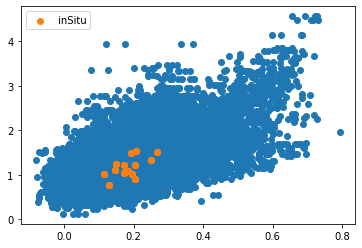

In [16]:
# TODO contour plot lines needed for clarity
plt.scatter(global_df.loc[:,'ndvi'], global_df.loc[:,'str'])
plt.scatter(inSitu_df.loc[:,'ndvi'], inSitu_df.loc[:,'str'], label = 'inSitu')
plt.legend()
plt.show()

# OPTRAM FIT

In [40]:
def W(STRd, STRw, STR):
    return((STR - STRd)/(STRw - STRd))

def STRd_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi) 

def STRw_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi)

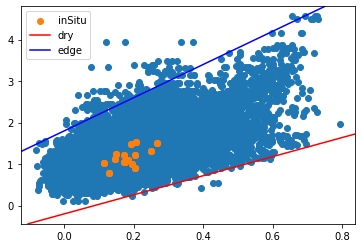

In [33]:
edge_dry_intercept = -0.2
edge_dry_slope = 2.3

edge_wet_intercept = 1.8 
edge_wet_slope = 4

plt.scatter(global_df.loc[:,'ndvi'], global_df.loc[:,'str'])
plt.scatter(inSitu_df.loc[:,'ndvi'], inSitu_df.loc[:,'str'], label = 'inSitu')
plt.axline((0, edge_dry_intercept), slope=edge_dry_slope, color='red', label='dry')
plt.axline((0, edge_wet_intercept), slope=edge_wet_slope, color='blue', label='edge')
plt.legend()
plt.show()

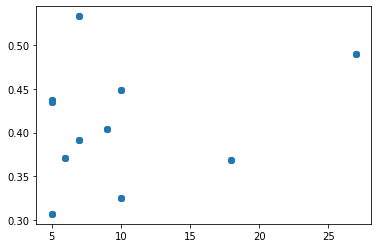

In [51]:
str_d =  STRd_f(intercept = edge_dry_intercept,
                slope = edge_dry_slope,
                ndvi  = inSitu_df.loc[:,'ndvi'])

str_w =  STRd_f(intercept = edge_wet_intercept,
                slope = edge_wet_slope,
                ndvi  = inSitu_df.loc[:,'ndvi'])

inSitu_df["W"] = W(STRd = str_d, STRw = str_w, STR = inSitu_df.loc[:,'str'])
inSitu_df["W_alt"] = (edge_dry_intercept + edge_dry_slope*inSitu_df.loc[:,'ndvi'] - inSitu_df.loc[:,'str'])/(edge_dry_intercept - edge_wet_intercept +(edge_dry_slope - edge_wet_slope)*inSitu_df.loc[:,'ndvi'])

plt.scatter(inSitu_df.loc[:,'SM5'], inSitu_df.loc[:,'W'])

# BASURA

In [ ]:
type(boa)

In [ ]:
py, px = boa.index(RG28_latlong[0], RG28_latlong[1]) # px coordinaes

print(px, py)

In [ ]:
BASE_DIR_BOA

#listdir(BASE_DIR_BOA)

In [ ]:
print(boa.indexes)
print(boa.dtypes)

In [ ]:
boa.profile

In [ ]:
boa.lnglat() #???

In [ ]:
boa.xy

In [ ]:
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
nir

In [ ]:
ndvi

In [ ]:
# https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
from shapely.geometry import Point

dataset = boa
val = ndvi
no_data = dataset.nodata
geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
df.crs = dataset.crs
geometry

In [ ]:
print(geometry[0].xy[0])

In [ ]:
boa.read(8, masked = True)

### NDVI band vs BOA computed ndvi

In [ ]:
import rasterio as rs

# NDVI 
ndvi_fp = './sen2r/indices/NDVI/S2A2A_20190415_041_Walnut-Gulch_NDVI_10.tif'
raster = rs.open(ndvi_fp)
print(raster.meta)

In [ ]:
raster_ndvi = raster.read(1)
raster_ndvi = np.ndarray.flatten(raster_ndvi)
raster_ndvi = np.delete(raster_ndvi, raster.mask)
print(raster_ndvi)

plt.hist(raster_ndvi, bins = 100)
plt.show()

In [ ]:
#STR
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA_2/'
boa_fp = "./sen2r/out/BOA_2/S2A2A_20190415_041_Walnut-Gulch_BOA_10.tif"
raster_date = S2_getDate(boa_fp)
#scl_fp = S2_getSCL(BASE_DIR, raster_date)

boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
r    = boa.read(3, masked = True)
nir  = boa.read(8, masked = True)
swir = boa.read(11, masked = True)
swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
#ndvi = (nir - r)/(nir + r)
STR  = ((1-swir)**2)/(2*swir)
scl  = scl.read(1, masked = True)
print(boa.meta)
STR

In [ ]:
STR  = np.ndarray.flatten(STR)
STR  = np.delete(STR, STR.mask)

plt.hist(STR, bins = 100)
plt.show()

In [ ]:
STR

In [ ]:
plt.scatter(raster_ndvi, STR)
plt.show()

In [ ]:
print(len(raster_ndvi))
print(len(STR))

print(len(raster_ndvi) == len(STR))

In [ ]:
STR

----------

In [ ]:
STR

In [ ]:
def get_px_coords_from_raster(boa) :
    dataset = boa
    val = boa.read(3, masked = True)
    no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) 
    coords_utm = [(point.x, point.y)  for point in geometry]
    return (zip(*coords_utm))




get_px_coords_from_raster(STR)